# 🤖 Evaluación Híbrida de Proveedores: Random Forest + NSGA-II
Este cuaderno aplica un enfoque híbrido que combina:
- Un modelo **Random Forest** para predecir el `Desempeño Global` de proveedores.
- Un algoritmo de optimización **NSGA-II** para generar un frente de Pareto con múltiples criterios.


## 📚 Paso 1: Importar librerías necesarias

In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from deap import base, creator, tools, algorithms
import random

## 📂 Paso 2: Cargar archivo CSV de proveedores

In [4]:
from google.colab import files
import io

uploaded = files.upload()
for name in uploaded:
    df = pd.read_csv(io.BytesIO(uploaded[name]))
    break
df.head()

Saving proveedores_hibrido_simulado.csv to proveedores_hibrido_simulado.csv


,Proveedor,Costo_total,Calidad,Entrega_oportuna,Nivel_servicio,Sostenibilidad,Flexibilidad,Desempeno_global
0,Prov_001,20795,88.45,54.81,60.21,79.34,96.23,72.87
1,Prov_002,5860,91.61,97.03,85.12,63.12,95.96,87.44
2,Prov_003,43158,84.24,69.88,67.77,80.90,62.65,67.27
3,Prov_004,49732,97.05,75.89,62.84,60.44,84.77,68.99
4,Prov_005,16284,86.04,91.89,75.87,55.64,53.77,73.91


## 🌲 Paso 3: Modelo Random Forest para predecir desempeño global

In [5]:
# Seleccionar variables predictoras
X = df.drop(columns=['Proveedor', 'Desempeno_global'])
y = df['Desempeno_global']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R2 Score: {r2_score(y_test, y_pred):.2f}')

MAE: 2.24
R2 Score: 0.70


## 🧬 Paso 4: Aplicar NSGA-II para optimización multicriterio

In [8]:
# Objetivos: minimizar costo, maximizar calidad y entrega oportuna
objetivos = ['Costo_total', 'Calidad', 'Entrega_oportuna']

creator.create('FitnessMulti', base.Fitness, weights=(-1.0, 1.0, 1.0))
creator.create('Individual', list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register('attr_float', random.random)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(objetivos))
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

def evaluar(ind):
    idx = int(ind[0] * (len(df) - 1))
    # Check if idx is within bounds:
    idx = min(idx, len(df) - 1)
    fila = df.iloc[idx]
    return (fila['Costo_total'], fila['Calidad'], fila['Entrega_oportuna'])

toolbox.register('evaluate', evaluar)
toolbox.register('mate', tools.cxBlend, alpha=0.5)
toolbox.register('mutate', tools.mutPolynomialBounded, eta=1.0, low=0.0, up=1.0, indpb=0.1)
toolbox.register('select', tools.selNSGA2)

# Población inicial y evolución
pop = toolbox.population(n=50)
algorithms.eaMuPlusLambda(pop, toolbox, mu=50, lambda_=100, cxpb=0.6, mutpb=0.3, ngen=40, verbose=False)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


([[0.1582953712624239, 0.5991204528917133, 0.4775035425408444],
  [0.16254424601187245, 0.4042102833251936, 0.23675804752719903],
  [0.16254424601187245, 0.4042102833251936, 0.23675804752719903],
  [0.716502891493661, 0.7518537766113327, 0.23392256972093506],
  [0.26852669398563833, 0.37014998190114984, 0.2873514413820979],
  [0.8854123712046078, 0.43691636710738313, 0.4629442610328155],
  [0.15514943359368982, 0.9759974178214966, 0.5870235292067426],
  [0.018847340287962353, 0.45224588252982184, 0.9428789590385735],
  [0.7060603307052115, 0.042820759470838854, 0.6273238990118568],
  [0.3901430257030999, 0.5786096934792124, 0.5831414046518731],
  [0.3901430257030999, 0.5786096934792124, 0.5831414046518731],
  [0.7295331221328869, -0.010161450588465876, -0.09530711752847135],
  [0.05815778813633607, 0.26888793783151244, 0.4280726836287149],
  [0.05815778813633607, 0.26888793783151244, 0.4280726836287149],
  [0.2643020497627887, 0.27595257060741574, 0.28654740194005074],
  [0.34667631835

## 📈 Paso 5: Visualizar frente de Pareto

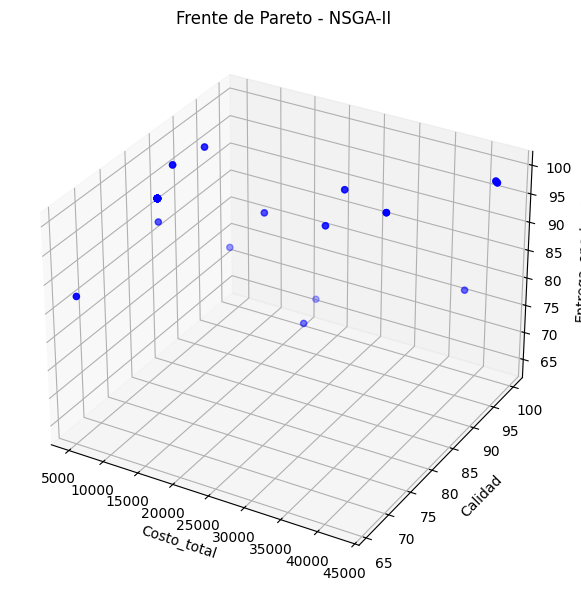

In [9]:
# Extraer resultados
pareto = np.array([ind.fitness.values for ind in pop])

# Gráfico 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pareto[:,0], pareto[:,1], pareto[:,2], c='blue', marker='o')
ax.set_xlabel('Costo_total')
ax.set_ylabel('Calidad')
ax.set_zlabel('Entrega_oportuna')
ax.set_title('Frente de Pareto - NSGA-II')
plt.tight_layout()
plt.show()

# 📋 Mostrar clasificación de proveedores seleccionados del frente de Pareto

In [10]:
# Identificar los índices más representativos del frente
indices = [int(ind[0] * (len(df)-1)) for ind in pop]
resultados = df.iloc[indices][['Proveedor', 'Costo_total', 'Calidad', 'Entrega_oportuna']].drop_duplicates()
resultados = resultados.sort_values(by='Costo_total')
resultados.reset_index(drop=True, inplace=True)
resultados.head(10)  # Mostrar top 10 proveedores seleccionados

,Proveedor,Costo_total,Calidad,Entrega_oportuna
0,Prov_070,5161,65.92,87.39
1,Prov_029,5189,82.53,89.27
2,Prov_002,5860,91.61,97.03
3,Prov_013,6685,83.65,99.11
4,Prov_095,7568,94.33,77.64
5,Prov_016,10311,75.32,99.81
6,Prov_006,11265,96.60,83.78
7,Prov_035,16394,97.71,64.20
8,Prov_088,17185,99.34,67.93
9,Prov_007,21850,94.00,86.76
